In [41]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from utils.data import load_breast_cancer_kagglehub, standardize_fit_transform
from utils.internal_metrics import (
    silhouette_score,
    davies_bouldin_index,
    calinski_harabasz_index,
    wcss,
)
from utils.external_metrics import (
    adjusted_rand_index,
    normalized_mutual_info,
    purity_score,
)
from GMM import GMM

In [42]:
X, y, feature_names = load_breast_cancer_kagglehub()
Xs, scaler = standardize_fit_transform(X)
print("Data shape:", Xs.shape)

Loaded CSV: /home/amr/.cache/kagglehub/datasets/uciml/breast-cancer-wisconsin-data/versions/2/data.csv
Data shape: (569, 30)


In [ ]:
cov_types = ['full', 'tied', 'diag', 'spherical']
components_range = range(1, 3)  # try 1 to 2 components

# Dictionary to store results
results = {}

In [44]:
for cov in cov_types:
    bic_list = []
    aic_list = []
    loglik_list = []
    gmm_models = []
    
    for k in components_range:
        gmm = GMM(n_components=k, covariance_type=cov, max_iter=200, random_state=42)
        gmm.fit(Xs)
        
        bic_list.append(gmm.bic(Xs))
        aic_list.append(gmm.aic(Xs))
        loglik_list.append(gmm.log_likelihoods_)
        gmm_models.append(gmm)
    
    results[cov] = {
        'BIC': bic_list,
        'AIC': aic_list,
        'loglik': loglik_list,
        'models': gmm_models
    }

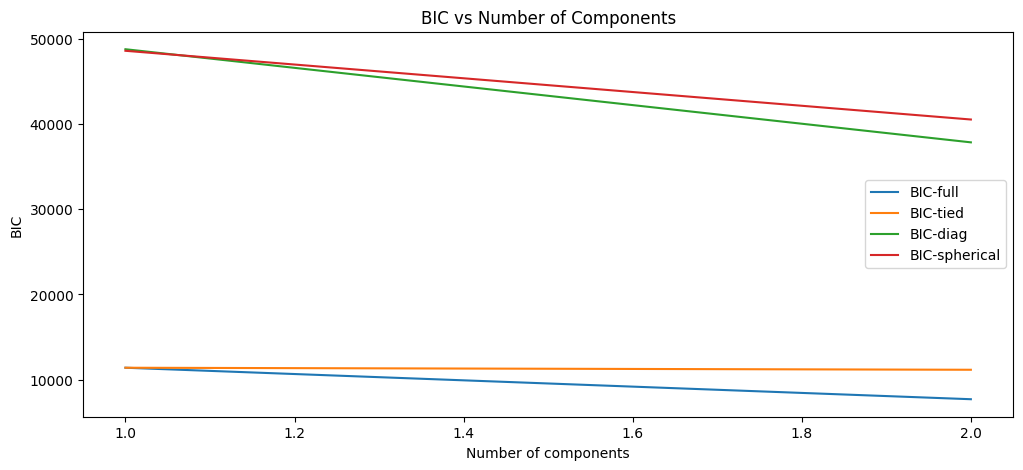

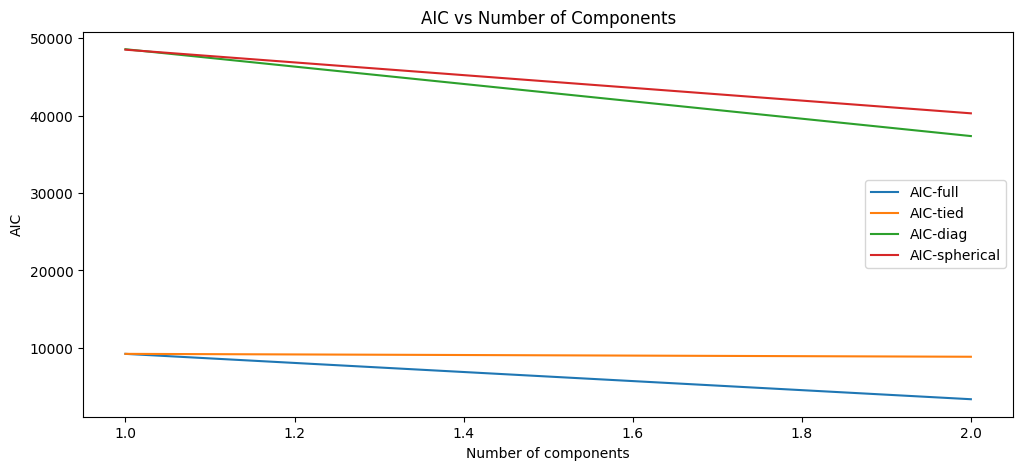

In [45]:
plt.figure(figsize=(12,5))
for cov in cov_types:
    plt.plot(components_range, results[cov]['BIC'], label=f'BIC-{cov}')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.title('BIC vs Number of Components')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
for cov in cov_types:
    plt.plot(components_range, results[cov]['AIC'], label=f'AIC-{cov}')
plt.xlabel('Number of components')
plt.ylabel('AIC')
plt.title('AIC vs Number of Components')
plt.legend()
plt.show()


In [46]:
optimal_components_bic = {}
optimal_components_aic = {}

for cov in cov_types:
    bic_list = results[cov]['BIC']
    aic_list = results[cov]['AIC']
    optimal_components_bic[cov] = components_range[np.argmin(bic_list)]
    optimal_components_aic[cov] = components_range[np.argmin(aic_list)]

print("Optimal number of components based on BIC:", optimal_components_bic)
print("Optimal number of components based on AIC:", optimal_components_aic)


Optimal number of components based on BIC: {'full': 2, 'tied': 2, 'diag': 2, 'spherical': 2}
Optimal number of components based on AIC: {'full': 2, 'tied': 2, 'diag': 2, 'spherical': 2}


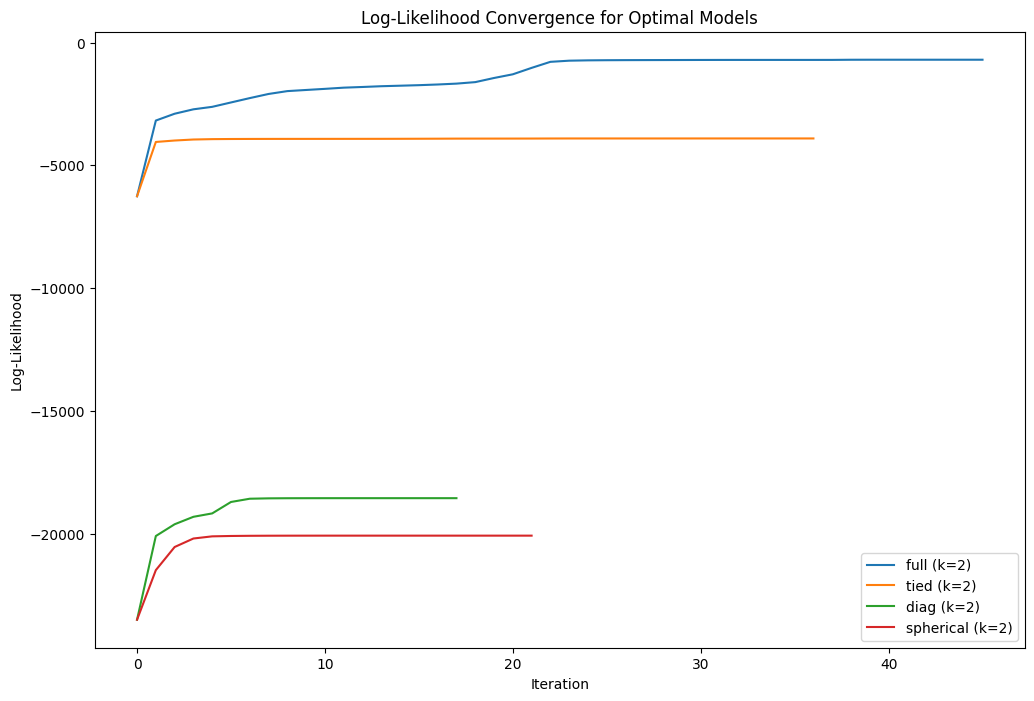

In [47]:
plt.figure(figsize=(12,8))
for cov in cov_types:
    best_k = optimal_components_bic[cov]
    best_gmm = results[cov]['models'][best_k-1]
    plt.plot(best_gmm.log_likelihoods_, label=f'{cov} (k={best_k})')

plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood Convergence for Optimal Models')
plt.legend()
plt.show()


In [48]:
assert not np.isnan(gmm.log_likelihoods_).any()
assert not np.isinf(gmm.log_likelihoods_).any()

print("GMM passed numerical stability check ✔")

GMM passed numerical stability check ✔


In [49]:
for cov in cov_types:
    best_k = optimal_components_bic[cov]
    best_gmm = results[cov]['models'][best_k-1]
    y_pred = best_gmm.predict(Xs)
    
    ari = adjusted_rand_index(y, y_pred)
    nmi = normalized_mutual_info(y, y_pred)
    pur = purity_score(y, y_pred)
    
    print(f"{cov} | k={best_k} -> ARI: {ari:.4f}, NMI: {nmi:.4f}, Purity: {pur:.4f}")


full | k=2 -> ARI: -0.0214, NMI: 0.0180, Purity: 0.6274
tied | k=2 -> ARI: 0.0668, NMI: 0.1073, Purity: 0.6714
diag | k=2 -> ARI: 0.6779, NMI: 0.5603, Purity: 0.9121
spherical | k=2 -> ARI: 0.5456, NMI: 0.4303, Purity: 0.8699
